In [2]:
import pandas as pd
import numpy as np
import datetime
import time

country= 'United Kingdom'     # Country for data

N = 66.7e6               # Population Size
data_end   = "4/26/21" # End date for data
data_begin = "4/19/21" # Start date for data

confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
cases_raw = pd.read_csv(confirmed_cases_url,index_col='Country/Region')
cases_grouped = cases_raw .groupby('Country/Region') .sum()
cases_numbers = cases_grouped .drop(['Lat', 'Long'],axis=1)
cases_country = cases_numbers .loc[country]
cases_framed  = cases_country .loc[data_begin:data_end]
cases         = np.array(cases_framed)

days = len(cases)

np.random.seed(0)

path_to_save = ';'

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<ipython-input-3-dd371d5943a6>:52: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=500, tune=800, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\wrigh\appdata\local\programs\python\python39\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encounter

Sampling 2 chains for 800 tune and 500 draw iterations (1_600 + 1_000 draws total) took 378 seconds.
The number of effective samples is smaller than 25% for some parameters.


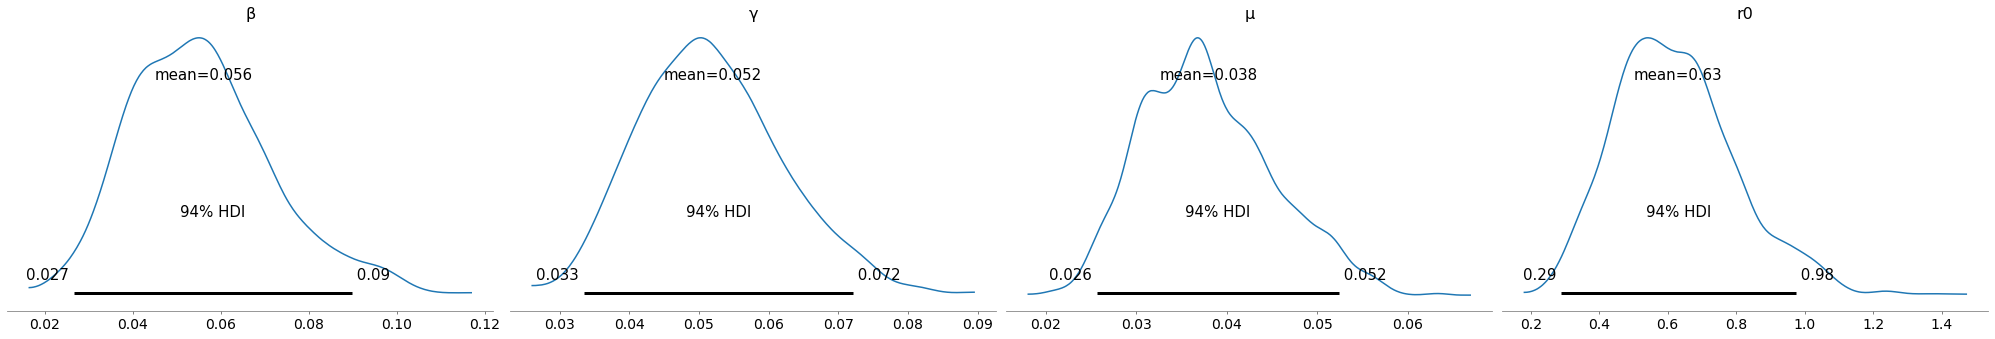

In [3]:
import pymc3 as pm
import theano.tensor as tt
import theano
import arviz as az

def SIRD(β,γ,μ, S0, I0, N):
    new_I0 =tt.zeros_like(I0)
    def step(β, S, I, _):
        new_I = (β/N)*I*S
        S = S - new_I
        I = I + new_I - (γ+μ) * I
        return S,I, new_I
    outputs , _  = theano.scan(fn=step, sequences=[β], 
                               outputs_info=[S0, I0, new_I0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

with pm.Model() as model:
    
    # cases at beginning of confirmed data.
    I0 = pm.Lognormal("I0", mu=np.log(cases[0]), sigma=0.9)

    # fraction of new infections each time step
    β = pm.Lognormal("β", mu=np.log(0.4), sigma=0.5)

    # fraction of recoveries each time step
    γ = pm.Lognormal('γ', mu=np.log(1/21), sigma=0.2)
    
    # fraction of deaths each time step
    μ = pm.Lognormal('μ', mu=np.log(1/28), sigma=0.2)
    
    # reproduction number
    r0=pm.Deterministic("r0", β/(γ+μ))
    
    # error in observed data
    σ = pm.HalfCauchy("σ", beta=1)
    
    S0 = N - I0
    S_past, I_past, new_I_past = SIRD(β=β * tt.ones(days-1),γ=γ, μ=μ, 
                                               S0=S0, I0=I0,
                                               N=N)
    new_cases_obs = np.diff(cases)

    pm.StudentT(
        "obs",
        nu=4,
        mu=new_I_past,
        sigma=new_I_past ** 0.5 * σ,
        observed=new_cases_obs
        )  
    
    trace = pm.sample(draws=500, tune=800, chains=2)
    data = az.from_pymc3(trace=trace)
    ax=az.plot_posterior(data,var_names=['β','γ','μ','r0']);
    fig1 = ax.ravel()[0].figure
    fig1.savefig('Estimations_plot.png', dpi=300)

In [4]:
az.summary(trace)
 

c:\users\wrigh\appdata\local\programs\python\python39\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I0,52003.249,18866.387,21954.685,84236.245,1060.928,804.953,381.0,391.0,1.01
β,0.056,0.017,0.027,0.090,0.001,0.001,365.0,305.0,1.01
γ,0.052,0.011,0.033,0.072,0.001,0.000,397.0,384.0,1.01
μ,0.038,0.008,0.026,0.052,0.000,0.000,378.0,351.0,1.00
r0,0.629,0.191,0.289,0.975,0.008,0.006,477.0,380.0,1.01
σ,5.620,2.037,2.303,9.144,0.122,0.087,214.0,102.0,1.00
